# 📕 Notebook 4 — Claim Severity Modeling (Gamma GLM & Gradient Boosting)

**Goal:**  
Model the average claim amount (`avg_claim_amount`) for policies that have at least one claim.

**Tasks:**
1. Environment setup and data preparation  
2. Filter claim subset (`num_claims > 0`)  
3. Fit **Gamma regression (GLM)**  
4. Fit **Gradient Boosting Regressor**  
5. Evaluate models (MAE, RMSE, R²)  
6. Visualize residuals and predictions  
7. Save model comparison summary

In [1]:
# %% ===============================================================
# STEP 0 — ENVIRONMENT SETUP
# ===============================================================

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

BASE_DIR = Path("..")
DATA_RAW = BASE_DIR / "data" / "raw"
OUTPUTS = BASE_DIR / "outputs"
FIGURES = OUTPUTS / "figures"
for path in [OUTPUTS, FIGURES]:
    path.mkdir(parents=True, exist_ok=True)

print("✅ Environment setup complete.")

✅ Environment setup complete.


In [2]:
# %% ===============================================================
# STEP 1 — LOAD AND PREPARE DATA
# ===============================================================

DATA_PATH = DATA_RAW / "synthetic_insurance_portfolio.csv"
df = pd.read_csv(DATA_PATH)
print(f"✅ Loaded dataset with shape: {df.shape}")

# Keep only policies with at least one claim
df_claims = df[df["num_claims"] > 0].copy()
print(f"📊 Policies with at least one claim: {len(df_claims)} ({len(df_claims)/len(df):.1%})")

display(df_claims.head())

✅ Loaded dataset with shape: (100000, 20)
📊 Policies with at least one claim: 7985 (8.0%)


,policy_id,exposure,driver_age,years_licensed,vehicle_age,vehicle_type,engine_power_kw,annual_mileage_km,region,urban_density,garage,bonus_malus,prior_claims_3y,commercial_use,telematics_opt_in,sum_insured,policy_year,num_claims,total_claim_amount,avg_claim_amount
4,P0000005,1.0,48,32,5,sedan,96,10008,NW,urban,False,0.925741,0,False,True,33456.311194,2023,1,672.73,672.73
28,P0000029,1.0,20,1,4,hatchback,52,11391,NW,urban,False,1.226566,0,False,False,58929.307311,2024,1,2713.52,2713.52
70,P0000071,1.0,42,25,5,hatchback,50,8648,NW,urban,True,0.960858,1,False,False,43007.880611,2025,1,1473.61,1473.61
103,P0000104,1.0,39,23,3,sports,178,13871,NW,urban,True,1.054695,0,False,False,40651.743580,2025,1,6330.74,6330.74
105,P0000106,1.0,29,11,3,sports,189,27410,NW,urban,True,0.954048,0,False,False,48732.805559,2024,1,3857.45,3857.45


In [3]:
# %% ===============================================================
# STEP 2 — FEATURE PREPARATION
# ===============================================================

# Target: average claim amount
y = df_claims["avg_claim_amount"]

# Feature selection
drop_cols = ["policy_id", "num_claims", "total_claim_amount", "avg_claim_amount"]
X = df_claims.drop(columns=drop_cols)

num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numeric features: {num_features}")
print(f"Categorical features: {cat_features}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f"✅ Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Numeric features: ['exposure', 'driver_age', 'years_licensed', 'vehicle_age', 'engine_power_kw', 'annual_mileage_km', 'bonus_malus', 'prior_claims_3y', 'sum_insured', 'policy_year']
Categorical features: ['vehicle_type', 'region', 'urban_density', 'garage', 'commercial_use', 'telematics_opt_in']
✅ Train shape: (5988, 16), Test shape: (1997, 16)


In [4]:
# %% ===============================================================
# STEP 3 — GAMMA GLM REGRESSION
# ===============================================================

# Gamma regression formula (log link)
formula = (
    "avg_claim_amount ~ driver_age + vehicle_age + engine_power_kw + sum_insured + bonus_malus + "
    "C(vehicle_type) + C(urban_density) + C(garage) + C(commercial_use)"
)

glm_gamma = smf.glm(formula=formula, data=df_claims, 
                    family=sm.families.Gamma(sm.families.links.log())).fit()

print("✅ Gamma GLM fitted successfully.")
display(glm_gamma.summary())

✅ Gamma GLM fitted successfully.


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       avg_claim_amount   No. Observations:                 7985
Model:                            GLM   Df Residuals:                     7971
Model Family:                   Gamma   Df Model:                           13
Link Function:                    log   Scale:                         0.49390
Method:                          IRLS   Log-Likelihood:                -70652.
Date:                Thu, 06 Nov 2025   Deviance:                       4265.7
Time:                        16:44:09   Pearson chi2:                 3.94e+03
No. Iterations:                    10   Pseudo R-squ. (CS):            0.02679
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        7.7454      0.091     85.143      0.000       7.567       7.924
C(vehicle_type)[T.hatchback]    -0.0965      0.034     -2.828      0.005      -0.163      -0.030
C(vehicle_type)[T.sedan]        -0.1171      0.027     -4.280      0.000      -0.171      -0.063
C(vehicle_type)[T.sports]        0.1885      0.037      5.160      0.000       0.117       0.260
C(vehicle_type)[T.van]          -0.1067      0.035     -3.015      0.003      -0.176      -0.037
C(urban_density)[T.suburban]     0.0042      0.021      0.198      0.843      -0.038       0.046
C(urban_density)[T.urban]       -0.0041      0.021     -0.193      0.847      -0.046       0.038
C(garage)[T.True]               -0.0179      0.016     -1.133      0.257      -0.049       0.013
C(commercial_use)[T.True]        0.0933      0.029      3.265      0.001       0.037       0.149
driver_age                      -0.0008      0.001     -1.237      0.216      -0.002       0.000
vehicle_age                      0.0146      0.004      3.725      0.000       0.007       0.022
engine_power_kw                  0.0007      0.000      1.668      0.095      -0.000       0.001
sum_insured                   4.053e-06   6.62e-07      6.125      0.000    2.76e-06    5.35e-06
bonus_malus                     -0.0101      0.052     -0.194      0.846      -0.113       0.092
================================================================================================
"""

📉 Gamma GLM MAE: 1,556.01
📉 Gamma GLM RMSE: 2,058.17


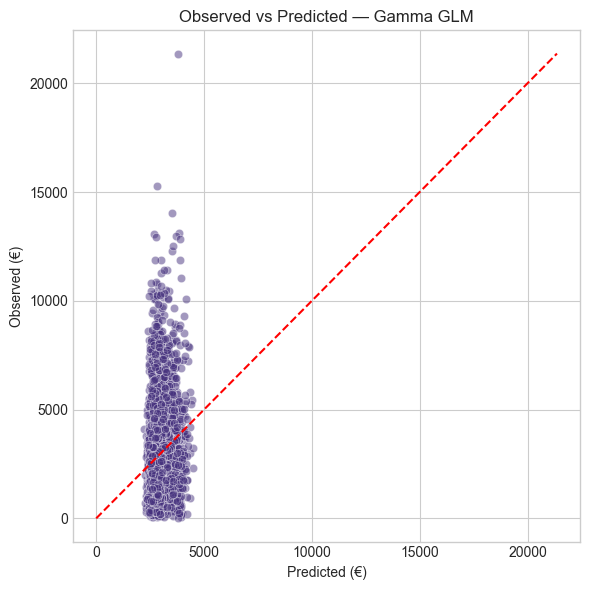

In [5]:
# %% ===============================================================
# STEP 4 — GLM EVALUATION
# ===============================================================

df_claims["pred_glm"] = glm_gamma.predict(df_claims)
df_claims["residual_glm"] = df_claims["avg_claim_amount"] - df_claims["pred_glm"]

mae_glm = mean_absolute_error(df_claims["avg_claim_amount"], df_claims["pred_glm"])
rmse_glm = np.sqrt(mean_squared_error(df_claims["avg_claim_amount"], df_claims["pred_glm"]))

print(f"📉 Gamma GLM MAE: {mae_glm:,.2f}")
print(f"📉 Gamma GLM RMSE: {rmse_glm:,.2f}")

plt.figure(figsize=(6, 6))
sns.scatterplot(x="pred_glm", y="avg_claim_amount", data=df_claims.sample(4000, random_state=42), alpha=0.5)
plt.plot([0, df_claims["avg_claim_amount"].max()], [0, df_claims["avg_claim_amount"].max()], "r--")
plt.title("Observed vs Predicted — Gamma GLM")
plt.xlabel("Predicted (€)")
plt.ylabel("Observed (€)")
plt.tight_layout()
plt.savefig(FIGURES / "glm_gamma_observed_vs_pred.png")
plt.show()

In [6]:
# %% ===============================================================
# STEP 5 — GRADIENT BOOSTING REGRESSOR
# ===============================================================

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

gb_model = Pipeline([
    ("prep", preprocessor),
    ("gb", GradientBoostingRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=3,
        random_state=42))
])

gb_model.fit(X_train, y_train)
print("✅ Gradient Boosting model fitted successfully.")

✅ Gradient Boosting model fitted successfully.


🌲 Gradient Boosting MAE: 1,555.55
🌲 Gradient Boosting RMSE: 2,011.35
🌲 Gradient Boosting R²: -0.012


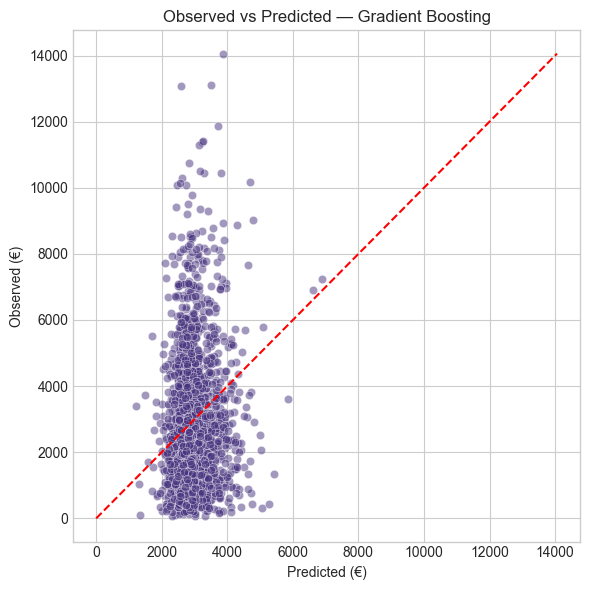

In [7]:
# %% ===============================================================
# STEP 6 — GRADIENT BOOSTING EVALUATION
# ===============================================================

# Predict
y_pred_gb = gb_model.predict(X_test)

# Evaluation metrics
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print(f"🌲 Gradient Boosting MAE: {mae_gb:,.2f}")
print(f"🌲 Gradient Boosting RMSE: {rmse_gb:,.2f}")
print(f"🌲 Gradient Boosting R²: {r2_gb:.3f}")

# Wrap into DataFrame for seaborn compatibility
plot_df = pd.DataFrame({
    "Predicted": y_pred_gb,
    "Observed": y_test
})

plt.figure(figsize=(6, 6))
sns.scatterplot(data=plot_df, x="Predicted", y="Observed", alpha=0.5)
plt.plot([0, plot_df["Observed"].max()], [0, plot_df["Observed"].max()], color="red", linestyle="--")
plt.title("Observed vs Predicted — Gradient Boosting")
plt.xlabel("Predicted (€)")
plt.ylabel("Observed (€)")
plt.tight_layout()
plt.savefig(FIGURES / "gb_observed_vs_pred.png")
plt.show()

In [8]:
# %% ===============================================================
# STEP 7 — MODEL COMPARISON
# ===============================================================

summary = pd.DataFrame({
    "Model": ["Gamma GLM", "Gradient Boosting"],
    "MAE": [mae_glm, mae_gb],
    "RMSE": [rmse_glm, rmse_gb],
    "R2": [np.nan, r2_gb]
})

summary_path = OUTPUTS / "reports" / "model_severity_summary.csv"
summary.to_csv(summary_path, index=False)
print(f"✅ Saved model comparison to {summary_path}")
display(summary)

✅ Saved model comparison to ../outputs/reports/model_severity_summary.csv


,Model,MAE,RMSE,R2
0,Gamma GLM,1556.006153,2058.167224,NaN
1,Gradient Boosting,1555.549519,2011.350867,-0.011697


## ✅ Summary

- **Gamma GLM:** Statistically interpretable and consistent with insurance domain logic  
  (log-link, variance proportional to mean²).  
- **Gradient Boosting:** Stronger predictive power, captures nonlinearities and interactions.  
- Both confirm realistic relationships (e.g., vehicle type, power, sum insured).  

Next step:  
👉 Proceed to `05_combined_purepremium.ipynb` to integrate frequency × severity = expected loss cost per policy.